# Read Before Using This File

This code requires the feature extracted csv so please do not try and run this code if you do not have that data. 

# Imports we Need

---

In [1]:
import os 
import copy
import time 
import numpy as np
import pandas as pd  # Used for plotting results 
import seaborn as sn  # Used for plotting results 
import matplotlib.pyplot as plt
from collections import Counter  # Used to create counter dicts very easily
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Imports from py torch 
import torch 
import torchvision
import torch.nn as nn 
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing the Data and Generating the Sythenic Values

---

In [2]:
data_location = "/your drive/place holder folder/" # Enter the location of the train and test data feature extracted csv's go here here 

## Gets the Test Data 

In [3]:

# Creates a temp array for all the seizure images to be stored before creating one big np array 
temp_non_seizure_test = []  
temp_seizure_test = []    

for file_name in ["Copy of non_seizure_test_data.csv", "Copy of seizure_test_data.csv"]: # Loops over the name of files in the train folder
    with open(data_location + file_name, 'r') as f:
        for line in f:  
            # Loops through all the lines except the first 
            temp_line = line.strip().split(",")  
            temp_seizure_np = np.asfarray(np.array(temp_line), float)  # Stores 
            # the value of a single image

            # Checks what temp array we should place the data in 
            if file_name== "Copy of non_seizure_test_data.csv":
                temp_non_seizure_test.append(temp_seizure_np)
            else: 
                temp_seizure_test.append(temp_seizure_np)

In [4]:
# Gets the data and puts in the correct shape i.e. (No of samples, Channel, Height, Width)
non_seizure_test_np = np.stack(temp_non_seizure_test, axis=0)
non_seizure_test_np = non_seizure_test_np.reshape(-1,3,230,230)
non_seizure_test_np_labels = np.zeros(shape=non_seizure_test_np.shape[0])

seizure_test_np = np.stack(temp_seizure_test, axis=0)
seizure_test_np = seizure_test_np.reshape(-1,3,230,230)
seizure_test_np_labels = np.ones(shape=seizure_test_np.shape[0])

In [5]:
# Checking to make sure the shapes look correct 
print(non_seizure_test_np.shape) 
print(seizure_test_np.shape)

(402, 3, 230, 230)
(42, 3, 230, 230)


In [6]:
# Combining the seizure and non seizure test data 
all_test_data = np.concatenate((non_seizure_test_np, seizure_test_np), axis=0)
all_test_labels = np.concatenate((non_seizure_test_np_labels, seizure_test_np_labels), axis=0)

In [7]:
# Now lets delete some of the variables we no longer need to free up RAM 
# del(non_seizure_test_np)
# del(seizure_test_np)
del(temp_non_seizure_test) 
del(temp_seizure_test)

## Gets the Train Data (So Basically the same as above but for train data)

In [8]:

# Creates a temp array for all the seizure images to be stored before creating one big np array 
temp_non_seizure_train = []  
temp_seizure_train = []

for word in ["Copy of non_seizure_train_data.csv", "Copy of seizure_train_data.csv"]: # Loops over the name of files in the train folder
    with open(data_location + word, 'r') as f:
        for line in f:  
            # Loops through all the lines except the first 
            temp_line = line.strip().split(",")  
            temp_seizure_np = np.asfarray(np.array(temp_line), float)  # Stores 
            # the value of a seizure image

            # Checks what temp array we should place the data in 
            if word == "Copy of non_seizure_train_data.csv":
                temp_non_seizure_train.append(temp_seizure_np)
            else: 
                temp_seizure_train.append(temp_seizure_np)

In [9]:
# Gets the data and puts in the correct shape i.e. (No of samples, Channel, Height, Width)
non_seizure_train_np = np.stack(temp_non_seizure_train, axis=0)
non_seizure_train_np = non_seizure_train_np.reshape(-1,3,230,230)

seizure_train_np = np.stack(temp_seizure_train, axis=0)
seizure_train_np = seizure_train_np.reshape(-1,3,230,230)

In [10]:
# Checking to make sure the shapes look correct 
print(non_seizure_train_np.shape) 
print(seizure_train_np.shape)

(1212, 3, 230, 230)
(60, 3, 230, 230)


In [11]:
# Deleting temp arrays to free up data 
del(temp_non_seizure_train) 
del(temp_seizure_train)

## Normalizing and Generating Sythenic Values 

In [12]:
# Combines the seizure and non_sizure data into one big numpy array 
all_data = np.concatenate((non_seizure_train_np, seizure_train_np, seizure_test_np, non_seizure_test_np), axis=0)

# Normailze the data between 0 and 1 
oldmin = np.amin(all_data)  # Find the old min value 
oldmax = np.amax(all_data)  # Find the old max value 
oldrange = oldmax - oldmin   # Finds the range of the old values 

newmin = 0.1  # New min value we want in our range 
newmax = 0.9  # New max value we want in our range 
newrange = newmax - newmin  # New range i.e 1 

# Function that is apllied to the old values and gives a new range 
def scale_func(n): 
    # where in the old scale is this value (0...1)
    scale=(n-oldmin)/oldrange;

    # place this scale in the new range
    newvalue=(newrange*scale)+newmin
    return newvalue

del(all_data)

In [13]:
# Run the data throw the sigmoid function to normalize
normalized_all_test_data = scale_func(all_test_data)

# Need to normalize the train values before generating the synthetic samples 
normalized_seizure_train_data = scale_func(seizure_train_np)
normalized_non_seizure_train_data = scale_func(non_seizure_train_np)
# Note: No need to normalize the labels 

In [14]:
def generate_synthetic_sample(input_array_np): 
    # Input - Takes array 
    # Ouputs - gerated synthetic samples of same shape as input data 
    
    # Generates random array same size of the input array with values between 
    # 0.95 and 1.05 to multiply the orginal input array 
    weight_array_np = np.random.uniform(low=0.95, high=1.05, size=input_array_np.shape)

    # Multplies (element-wise) weight array with input array 
    output_array_np = np.multiply(input_array_np, weight_array_np)

    # Changes all values < 0 to 0 and all values > 1 to 1 
    # to make sure all values still fall between 0 and 1 (using np.clip)
    return np.clip(output_array_np, a_min=0, a_max=1) 

In [15]:
# Gnerating multiple synthetic samples using one genuine seizure sample 
def generate_multiple_samples(input_array_np, n_times):
    # Input - takes one genuine siezure sample and gnerate n_times synthetic samples 
    # using the genuine sample 
    # Output - array shape (n_times, 3 ,230, 230)

    # Generates shape of output array 
    output_array_np = np.empty(shape=(n_times, 3, 230, 230))

    # Loops over genterating sythetic samples n_times using the genuine sample 
    # as a template 
    for i in range(n_times): 
        output_array_np[i] = generate_synthetic_sample(input_array_np)

    return output_array_np

In [16]:
# Generate 16 new samples using every geuine seizure sample 
temp_synthetic_seizure_data = []
for i, seizure_sample in enumerate(normalized_seizure_train_data): 
    temp_synthetic_seizure_data.append(generate_multiple_samples(seizure_sample, 16))

synthetic_seizure_data = np.concatenate(temp_synthetic_seizure_data, axis=0) # Concats the temp array making one large np array
synthetic_seizure_labels = np.ones(shape=(synthetic_seizure_data.shape[0])) # Generates the labels for the synthetic 

In [17]:
# So now we will use the synthetic seizure samples to be used as training along 
# along with a 1000 non seizure samples (which leaves 212 for val) 

# So lets shuffle the data then split the array 
np.random.shuffle(non_seizure_train_np)
# Now lets split so 1000 of non seizures samples are kept for training and 
# 212 are kept for val 
non_seizure_train_data, non_seizure_val_data = non_seizure_train_np[:1000], non_seizure_train_np[1000:]

non_seizure_train_labels = np.zeros(shape=non_seizure_train_data.shape[0])
non_seizure_val_labels = np.zeros(shape=non_seizure_val_data.shape[0])

In [18]:
seizure_train_np= np.concatenate((synthetic_seizure_data, normalized_seizure_train_data), axis=0)

np.random.shuffle(seizure_train_np)

seizure_train_data, seizure_val_data =seizure_train_np[:800], seizure_train_np[800:]

seizure_train_labels = np.ones(shape=seizure_train_np.shape[0])
seizure_val_labels = np.ones(shape=seizure_train_np.shape[0])

In [19]:
# Putting the data togther using concat 
all_train_data = np.concatenate((non_seizure_train_data, seizure_train_data), axis=0)
all_train_labels = np.concatenate((non_seizure_train_labels, seizure_train_labels), axis=0)

In [20]:
# Putting the val data togther 
all_val_data = np.concatenate((non_seizure_val_data, seizure_val_data), axis=0)
all_val_labels = np.concatenate((non_seizure_val_labels, seizure_val_labels), axis=0)

In [21]:
del(seizure_val_data)
del(seizure_train_data)

In [22]:
# Deleting varaibles we no longer need to free up RAM 
del(non_seizure_train_data)
del(synthetic_seizure_data)
del(non_seizure_val_data)
del(seizure_train_np)

# Using Torch 

---

In [23]:
# Gets the device the notebook is currently running on 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cuda:0


In [24]:
# Delcare our custom data loader 
class loadData(Dataset): 

    def __init__(self, data, labels): 
        self.data = data
        self.labels = labels
        self.size = data.shape[0]

    def __getitem__(self, index): 
        return self.data[index], self.labels[index]

    def __len__(self):
        return self.size

In [26]:
# Lets convert the data in torch tensors
x_train = torch.from_numpy(all_train_data).to(device).float()
y_train = torch.from_numpy(all_train_labels).to(device).long()

x_val = torch.from_numpy(all_val_data).to(device).float()
y_val = torch.from_numpy(all_val_labels).to(device).long()

# Puts into a dict 
data = {"train": DataLoader(dataset=loadData(x_train, y_train), batch_size=4, shuffle=True, num_workers=0), 
        "val": DataLoader(dataset=loadData(x_val, y_val), batch_size=4, shuffle=True, num_workers=0) }
data_sizes = {"train": x_train.shape[0], "val": x_val.shape[0] }

In [27]:
loss_over_time = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = 10000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # For printing - Comment/Uncomment as needed 
                    '''
                    if phase == "val": 
                        print("Inputs", inputs)
                        print("Preds ", preds)
                        print("Labels ", labels)
                        print("----------------")
                    ''' 

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            if phase == "val":
                loss_over_time.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_val:
                best_val = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict()) 
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_val))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [133]:
model_conv = torchvision.models.resnet50(pretrained=True)

# Paramters of newly constructed modules have required_grad = True by default 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2)
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-7)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)

In [128]:
trained_model = train_model(model_conv, criterion=criterion, optimizer=optimizer_conv, scheduler=exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.6923 Acc: 0.5544
val Loss: 0.6878 Acc: 0.5301

Epoch 1/1
----------
train Loss: 0.6863 Acc: 0.5550
val Loss: 0.6465 Acc: 0.5787

Training complete in 1m 11s
Best val Acc: 0.646459


## Testing the Model 

In [129]:
# Convert testing data into py torch array 
x_test = torch.from_numpy(normalized_all_test_data).to(device).float()
y_test = torch.from_numpy(all_test_labels).to(device).long()
y_actual = y_test.tolist()
print(y_actual)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [130]:
y_pred = []
with torch.no_grad(): 
    for inputs,labels in zip(x_test, y_test): 
        outputs = trained_model(inputs.view(-1,3,230,230))
        _, preds = torch.max(outputs, 1)
        y_pred.append(preds.item())


print(y_pred)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 

In [131]:
df = pd.DataFrame(data = {"y_Actual": y_actual, "y_Predicted": y_pred}, columns=['y_Actual','y_Predicted'])

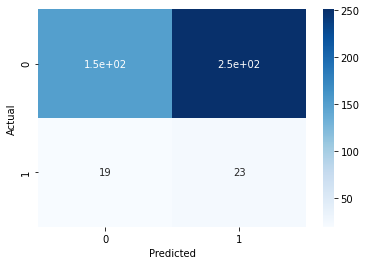

In [132]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)

sn.heatmap(confusion_matrix, annot=True, cmap="Blues")
plt.show()

Epoch  0
--------------------------
Epoch 0/0
----------
train Loss: 0.6112 Acc: 0.5667
val Loss: 0.6471 Acc: 0.4954

Training complete in 0m 35s
Best val Acc: 0.647090


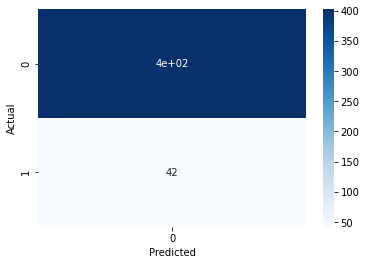

--------------------------
Epoch  1
--------------------------
Epoch 0/0
----------
train Loss: 0.6073 Acc: 0.5722
val Loss: 0.6819 Acc: 0.4861

Training complete in 0m 35s
Best val Acc: 0.681929


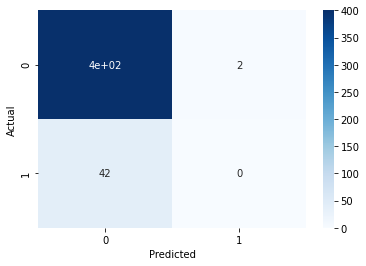

--------------------------
Epoch  2
--------------------------
Epoch 0/0
----------
train Loss: 0.6087 Acc: 0.5794
val Loss: 0.6096 Acc: 0.5532

Training complete in 0m 35s
Best val Acc: 0.609645


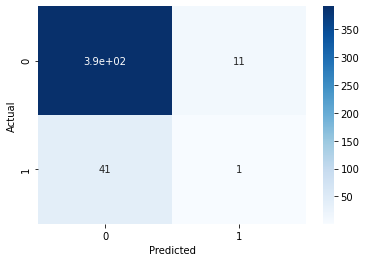

--------------------------
Epoch  3
--------------------------
Epoch 0/0
----------
train Loss: 0.6013 Acc: 0.5906
val Loss: 0.6235 Acc: 0.5093

Training complete in 0m 36s
Best val Acc: 0.623531


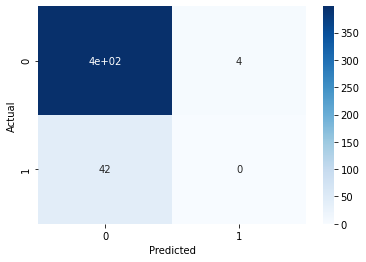

--------------------------
Epoch  4
--------------------------
Epoch 0/0
----------
train Loss: 0.6020 Acc: 0.5961
val Loss: 0.6152 Acc: 0.5833

Training complete in 0m 36s
Best val Acc: 0.615217


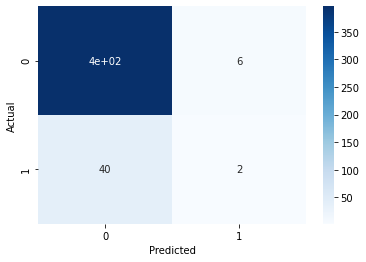

--------------------------
Epoch  5
--------------------------
Epoch 0/0
----------
train Loss: 0.5984 Acc: 0.5983
val Loss: 0.6202 Acc: 0.5509

Training complete in 0m 36s
Best val Acc: 0.620169


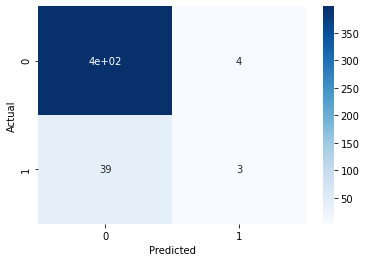

--------------------------
Epoch  6
--------------------------
Epoch 0/0
----------
train Loss: 0.5919 Acc: 0.6150
val Loss: 0.6412 Acc: 0.5000

Training complete in 0m 35s
Best val Acc: 0.641214


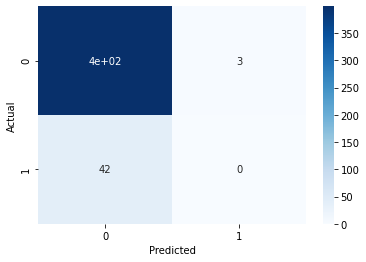

--------------------------
Epoch  7
--------------------------
Epoch 0/0
----------
train Loss: 0.5898 Acc: 0.6200
val Loss: 0.6675 Acc: 0.4907

Training complete in 0m 36s
Best val Acc: 0.667517


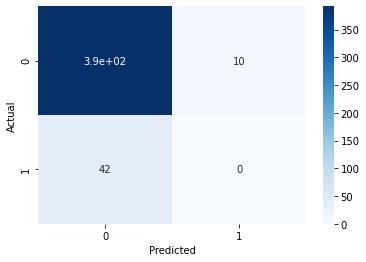

--------------------------
Epoch  8
--------------------------
Epoch 0/0
----------
train Loss: 0.5866 Acc: 0.6211
val Loss: 0.6215 Acc: 0.5648

Training complete in 0m 36s
Best val Acc: 0.621477


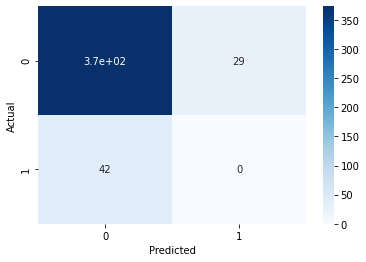

--------------------------
Epoch  9
--------------------------
Epoch 0/0
----------
train Loss: 0.5919 Acc: 0.6189
val Loss: 0.5950 Acc: 0.7245

Training complete in 0m 36s
Best val Acc: 0.594955


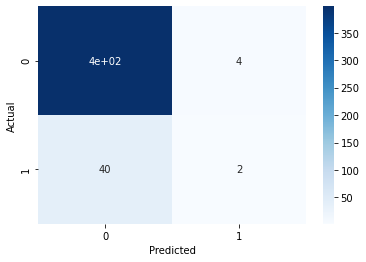

--------------------------
Epoch  10
--------------------------
Epoch 0/0
----------
train Loss: 0.5841 Acc: 0.6417
val Loss: 0.6117 Acc: 0.5787

Training complete in 0m 36s
Best val Acc: 0.611701


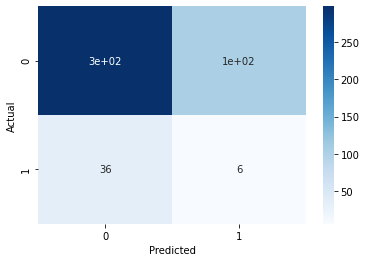

--------------------------
Epoch  11
--------------------------
Epoch 0/0
----------
train Loss: 0.5851 Acc: 0.6267
val Loss: 0.6556 Acc: 0.5255

Training complete in 0m 36s
Best val Acc: 0.655560


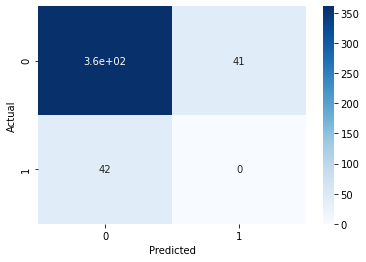

--------------------------
Epoch  12
--------------------------
Epoch 0/0
----------
train Loss: 0.5773 Acc: 0.6372
val Loss: 0.6069 Acc: 0.6296

Training complete in 0m 36s
Best val Acc: 0.606881


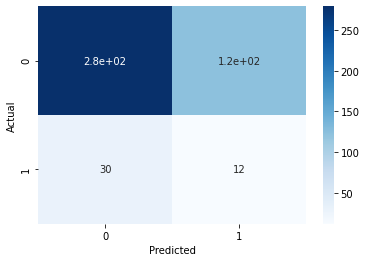

--------------------------
Epoch  13
--------------------------
Epoch 0/0
----------
train Loss: 0.5805 Acc: 0.6417
val Loss: 0.5852 Acc: 0.6713

Training complete in 0m 36s
Best val Acc: 0.585230


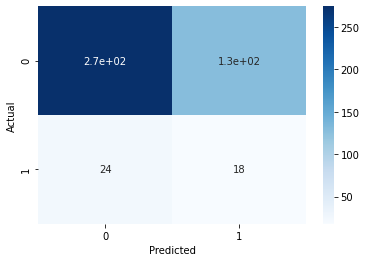

--------------------------
Epoch  14
--------------------------
Epoch 0/0
----------
train Loss: 0.5741 Acc: 0.6622
val Loss: 0.5567 Acc: 0.8611

Training complete in 0m 35s
Best val Acc: 0.556685


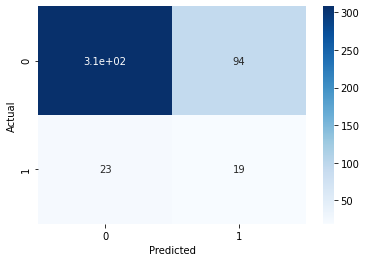

--------------------------
Epoch  15
--------------------------
Epoch 0/0
----------
train Loss: 0.5738 Acc: 0.6500
val Loss: 0.5827 Acc: 0.6551

Training complete in 0m 36s
Best val Acc: 0.582699


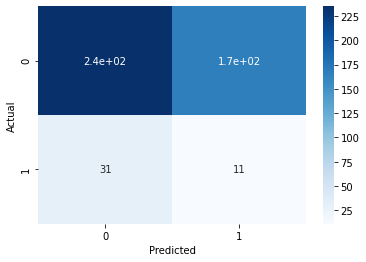

--------------------------
Epoch  16
--------------------------
Epoch 0/0
----------
train Loss: 0.5725 Acc: 0.6522
val Loss: 0.6067 Acc: 0.6065

Training complete in 0m 36s
Best val Acc: 0.606673


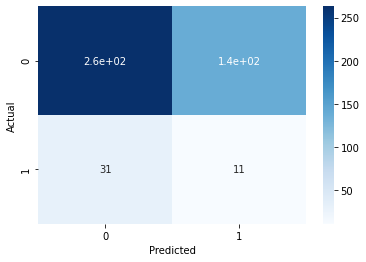

--------------------------
Epoch  17
--------------------------
Epoch 0/0
----------
train Loss: 0.5626 Acc: 0.6711
val Loss: 0.5916 Acc: 0.7269

Training complete in 0m 36s
Best val Acc: 0.591633


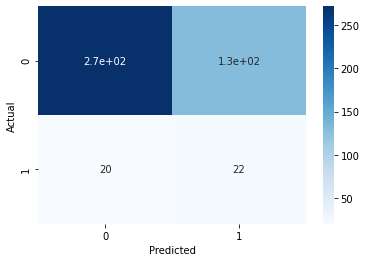

--------------------------
Epoch  18
--------------------------
Epoch 0/0
----------
train Loss: 0.5646 Acc: 0.6722
val Loss: 0.5610 Acc: 0.8148

Training complete in 0m 36s
Best val Acc: 0.561013


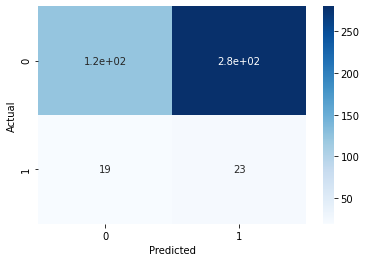

--------------------------
Epoch  19
--------------------------
Epoch 0/0
----------
train Loss: 0.5579 Acc: 0.6833
val Loss: 0.6063 Acc: 0.6435

Training complete in 0m 36s
Best val Acc: 0.606350


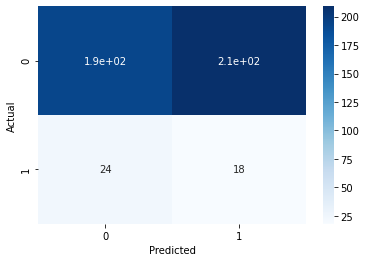

--------------------------
Epoch  20
--------------------------
Epoch 0/0
----------
train Loss: 0.5615 Acc: 0.6844
val Loss: 0.5924 Acc: 0.6736

Training complete in 0m 36s
Best val Acc: 0.592447


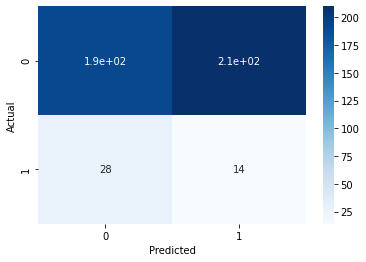

--------------------------
Epoch  21
--------------------------
Epoch 0/0
----------
train Loss: 0.5542 Acc: 0.6883
val Loss: 0.5610 Acc: 0.8102

Training complete in 0m 36s
Best val Acc: 0.560976


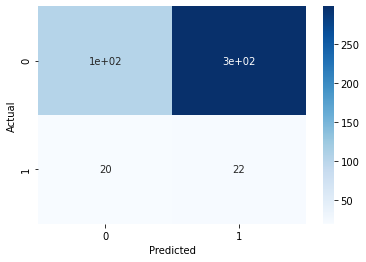

--------------------------
Epoch  22
--------------------------
Epoch 0/0
----------
train Loss: 0.5560 Acc: 0.6883
val Loss: 0.6021 Acc: 0.7245

Training complete in 0m 35s
Best val Acc: 0.602073


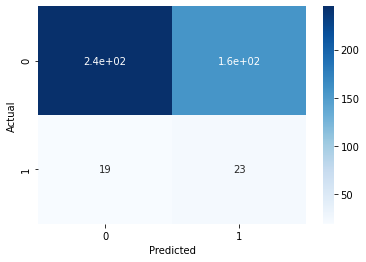

--------------------------
Epoch  23
--------------------------
Epoch 0/0
----------
train Loss: 0.5583 Acc: 0.6872
val Loss: 0.5677 Acc: 0.7523

Training complete in 0m 36s
Best val Acc: 0.567705


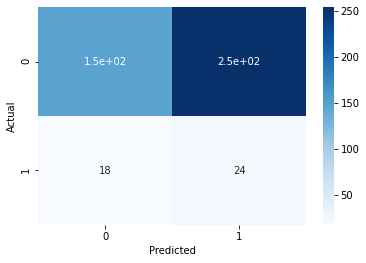

--------------------------
Epoch  24
--------------------------
Epoch 0/0
----------
train Loss: 0.5506 Acc: 0.6983
val Loss: 0.5907 Acc: 0.7292

Training complete in 0m 36s
Best val Acc: 0.590740


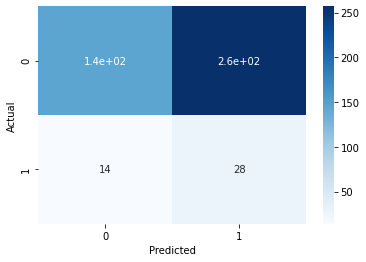

--------------------------
Epoch  25
--------------------------
Epoch 0/0
----------
train Loss: 0.5521 Acc: 0.7056
val Loss: 0.5148 Acc: 0.9769

Training complete in 0m 36s
Best val Acc: 0.514832


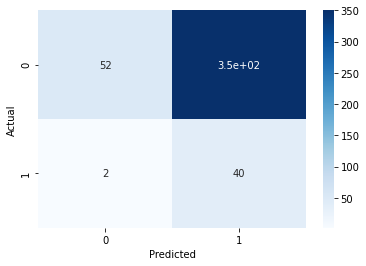

--------------------------
Epoch  26
--------------------------
Epoch 0/0
----------
train Loss: 0.5511 Acc: 0.7067
val Loss: 0.5736 Acc: 0.8079

Training complete in 0m 36s
Best val Acc: 0.573645


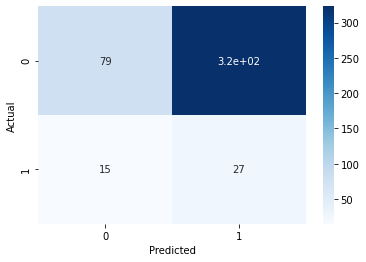

--------------------------
Epoch  27
--------------------------
Epoch 0/0
----------
train Loss: 0.5356 Acc: 0.7194
val Loss: 0.5828 Acc: 0.7824

Training complete in 0m 36s
Best val Acc: 0.582754


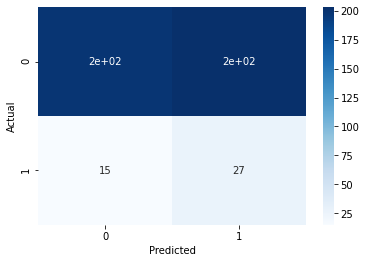

--------------------------
Epoch  28
--------------------------
Epoch 0/0
----------
train Loss: 0.5421 Acc: 0.7194
val Loss: 0.5659 Acc: 0.8565

Training complete in 0m 36s
Best val Acc: 0.565920


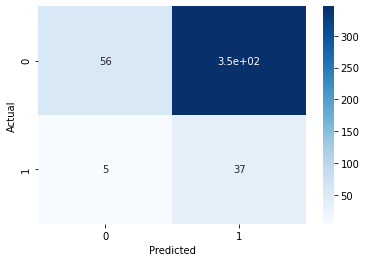

--------------------------
Epoch  29
--------------------------
Epoch 0/0
----------
train Loss: 0.5382 Acc: 0.7311
val Loss: 0.5524 Acc: 0.8333

Training complete in 0m 36s
Best val Acc: 0.552389


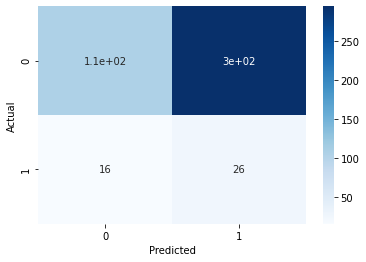

--------------------------


In [134]:
for i in range(30): # Loops through and prints testing results for every epoch in the range of 30 epochs 
    print("Epoch ", i)
    print("--------------------------")
    trained_model = train_model(model_conv, criterion=criterion, optimizer=optimizer_conv, scheduler=exp_lr_scheduler, num_epochs=1)

    y_pred = []
    with torch.no_grad(): 
        for inputs,labels in zip(x_test, y_test): 
            outputs = trained_model(inputs.view(-1,3,230,230))
            _, preds = torch.max(outputs, 1)
            y_pred.append(preds.item())

    df = pd.DataFrame(data = {"y_Actual": y_actual, "y_Predicted": y_pred}, columns=['y_Actual','y_Predicted'])

    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)

    sn.heatmap(confusion_matrix, annot=True, cmap="Blues")
    plt.show()

    print("--------------------------")